# Background Matching

When mosaicing, it is sometimes necessary to remove some uneven backgrounds because the sky brightness varies from one exposure to the next.

This notebook shows some techniques for matching image backgrounds _if_ they are flat (i.e., if there's no spatially-varying background).   If you have a spatially-varying background, this approach won't work, and the image needs to be better flat-fielded; it is not always possible to correct for such spatially-varying backgrounds.

In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
pl.rcParams['image.origin'] = 'lower'
pl.style.use('dark_background')
from astropy.io import fits

In [2]:
# these are 5 images that have already been aligned, combined, and then lined up into the final big mosaic frame
im1,im2,im3,im4,im5 = fits.getdata('data/m42_iband_bgmatch_cube.fits')

Look at your individual images and the combined mosaic.  If there's a 'quilted' pattern in the mosaic, as in the bottom-right example below, the backgrounds are poorly matched.

<ipython-input-3-0f3e80940b7b>:7: RuntimeWarning: Mean of empty slice
  pl.subplot(2,3,6).imshow(np.nanmean([im1,im2,im3,im4,im5], axis=0), vmin=-10, vmax=30); pl.axis((0,1500,0,1000))


(0.0, 1500.0, 0.0, 1000.0)

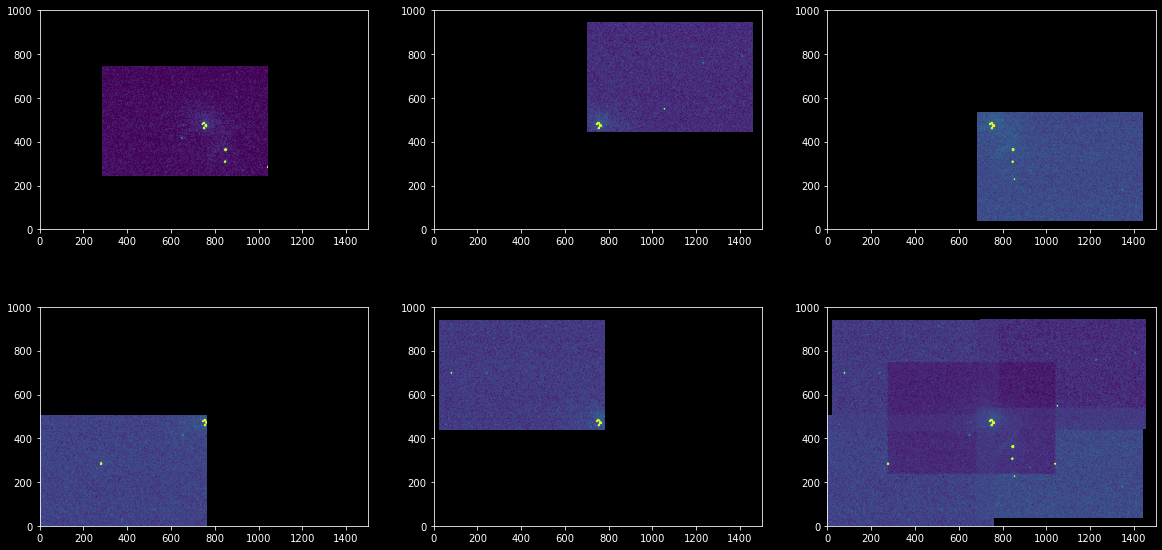

In [3]:
pl.figure(figsize=(20,10))
pl.subplot(2,3,1).imshow(im1, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,2).imshow(im2, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,3).imshow(im3, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,4).imshow(im4, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,5).imshow(im5, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,6).imshow(np.nanmean([im1,im2,im3,im4,im5], axis=0), vmin=-10, vmax=30); pl.axis((0,1500,0,1000))

Aside: warnings like this one can be safely ignored:

`<ipython-input-12-0f3e80940b7b>:7: RuntimeWarning: Mean of empty slice
  pl.subplot(2,3,6).imshow(np.nanmean([im1,im2,im3,im4,im5], axis=0), vmin=-10, vmax=30); pl.axis((0,1500,0,1000))`
  
We are taking the mean of 5 images.  This warning is telling us that there are some pixels that have _no values_ - all 5 images have `nan`, so the output is `nan`.  This is OK because we expect it!  There is blank space around all the images.

Note also that there are two ways to accomplish this same thing:

In [4]:
nanmean = np.nanmean([im1,im2,im3,im4,im5], axis=0)

countmean = np.nan_to_num([im1,im2,im3,im4,im5]).sum(axis=0) / (np.isfinite([im1,im2,im3,im4,im5]).sum(axis=0))

<ipython-input-4-2a4ba4a338a4>:1: RuntimeWarning: Mean of empty slice
  nanmean = np.nanmean([im1,im2,im3,im4,im5], axis=0)
<ipython-input-4-2a4ba4a338a4>:3: RuntimeWarning: invalid value encountered in true_divide
  countmean = np.nan_to_num([im1,im2,im3,im4,im5]).sum(axis=0) / (np.isfinite([im1,im2,im3,im4,im5]).sum(axis=0))


`countmean` is basically equivalent to this this:

```
countsic = np.isfinite(i_bigimc).astype('int')
countsitl = np.isfinite(i_bigimtl).astype('int')
countsibl = np.isfinite(i_bigimbl).astype('int')
countsibr = np.isfinite(i_bigimbr).astype('int')
countsitr = np.isfinite(i_bigimtr).astype('int')

i_bigim = np.sum(np.nan_to_num([i_bigimc,i_bigimtl,i_bigimbl,i_bigimbr,i_bigimtr]), axis=0) / (countsic+countsitl+countsibl+countsibr+countsitr) 
```

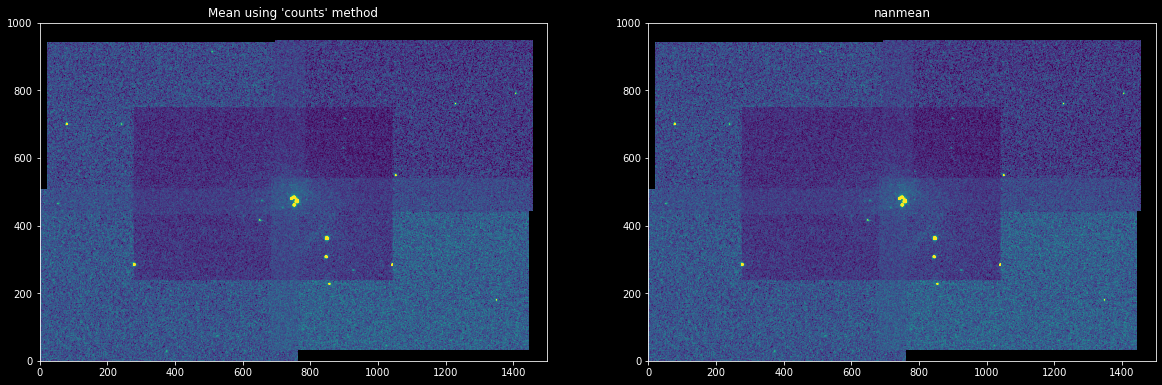

In [5]:
pl.figure(figsize=(20,10))
pl.subplot(1,2,1).imshow(countmean, vmin=-10, vmax=20);
pl.axis((0,1500,0,1000))
pl.title("Mean using 'counts' method")
pl.subplot(1,2,2).imshow(nanmean, vmin=-10, vmax=20); pl.axis((0,1500,0,1000))
_=pl.title("nanmean")

<ipython-input-6-08c5b3912fb1>:7: RuntimeWarning: Mean of empty slice
  _=pl.subplot(2,3,6).hist(np.nanmean([im1,im2,im3,im4,im5], axis=0).ravel(), bins=np.linspace(-30,50))


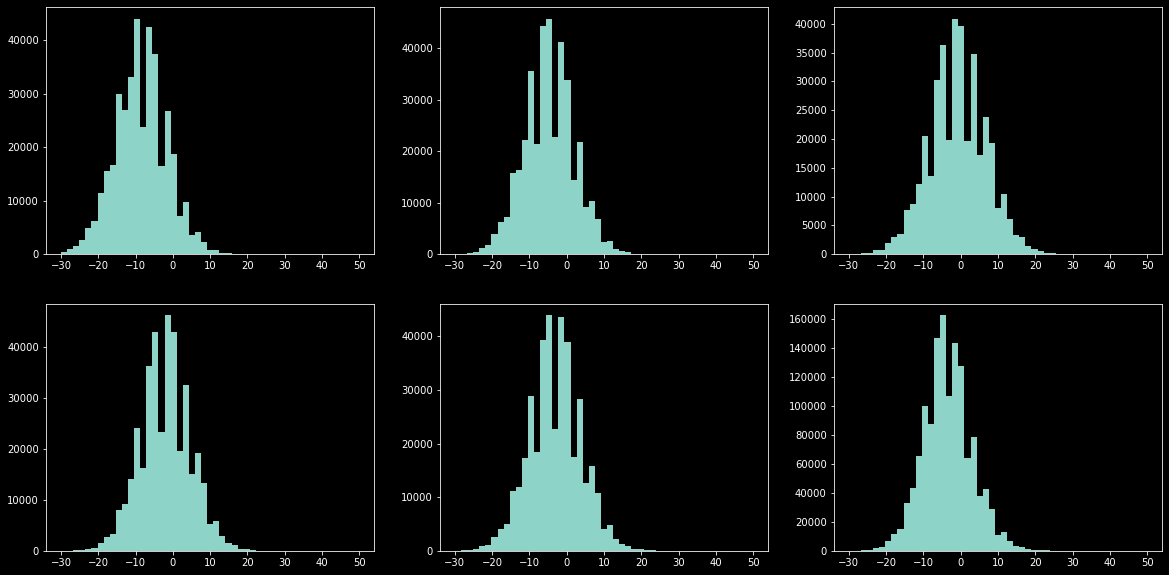

In [6]:
pl.figure(figsize=(20,10))
_=pl.subplot(2,3,1).hist(im1.ravel(), bins=np.linspace(-30,50));
_=pl.subplot(2,3,2).hist(im2.ravel(), bins=np.linspace(-30,50));
_=pl.subplot(2,3,3).hist(im3.ravel(), bins=np.linspace(-30,50));
_=pl.subplot(2,3,4).hist(im4.ravel(), bins=np.linspace(-30,50));
_=pl.subplot(2,3,5).hist(im5.ravel(), bins=np.linspace(-30,50));
_=pl.subplot(2,3,6).hist(np.nanmean([im1,im2,im3,im4,im5], axis=0).ravel(), bins=np.linspace(-30,50))

In this case, it is clear that the background level is typically below zero (negative).

We can correct this by estimating the background level.

In this specific case, the background is probably best estimated using the _median_.  The median will get approximately the middle of the distribution.  The mean might also be useful, but it will be biased by the bright sources in the center.

While the median is useful in this specific case, it may not always be!  If your source is very bright and extended, you may need to use a _different_ estimator of the background level, such as the median of a cutout.

In [7]:
# estimate and remove background
im1bgsub = im1 - np.nanmedian(im1)
im2bgsub = im2 - np.nanmedian(im2)
im3bgsub = im3 - np.nanmedian(im3)
im4bgsub = im4 - np.nanmedian(im4)
im5bgsub = im5 - np.nanmedian(im5)

<ipython-input-8-991754f3dea8>:7: RuntimeWarning: Mean of empty slice
  pl.subplot(2,3,6).imshow(np.nanmean([im1bgsub,


(0.0, 1500.0, 0.0, 1000.0)

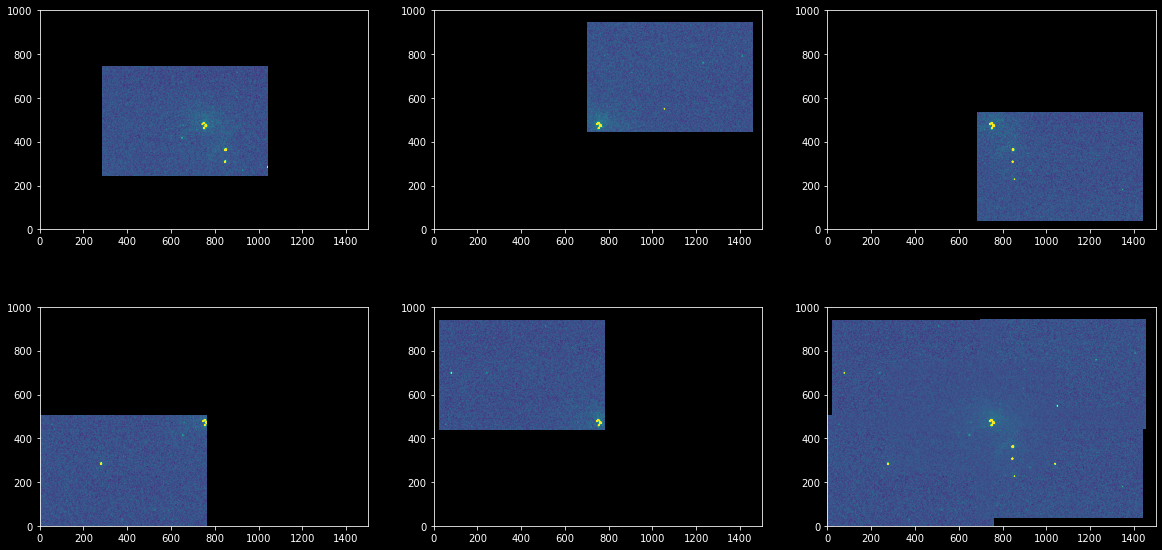

In [8]:
pl.figure(figsize=(20,10))
pl.subplot(2,3,1).imshow(im1bgsub, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,2).imshow(im2bgsub, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,3).imshow(im3bgsub, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,4).imshow(im4bgsub, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,5).imshow(im5bgsub, vmin=-10, vmax=30); pl.axis((0,1500,0,1000))
pl.subplot(2,3,6).imshow(np.nanmean([im1bgsub,
                                     im2bgsub,
                                     im3bgsub,
                                     im4bgsub,
                                     im5bgsub], axis=0), vmin=-10, vmax=30); pl.axis((0,1500,0,1000))

# Before vs After

<ipython-input-9-b943be26692b>:2: RuntimeWarning: Mean of empty slice
  pl.subplot(1,2,1).imshow(np.nanmean([im1,im2,im3,im4,im5], axis=0), vmin=-10, vmax=20);
<ipython-input-9-b943be26692b>:5: RuntimeWarning: Mean of empty slice
  pl.subplot(1,2,2).imshow(np.nanmean([im1bgsub,


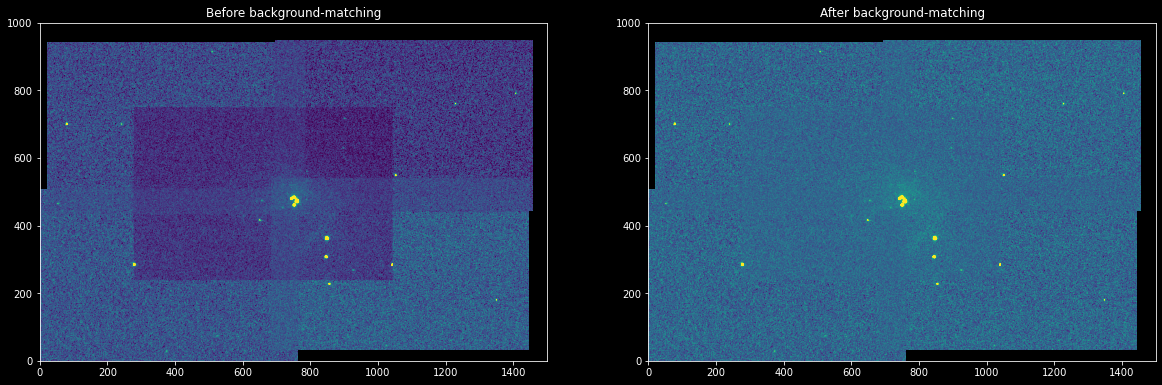

In [9]:
pl.figure(figsize=(20,10))
pl.subplot(1,2,1).imshow(np.nanmean([im1,im2,im3,im4,im5], axis=0), vmin=-10, vmax=20);
pl.axis((0,1500,0,1000))
pl.title("Before background-matching")
pl.subplot(1,2,2).imshow(np.nanmean([im1bgsub,
                                     im2bgsub,
                                     im3bgsub,
                                     im4bgsub,
                                     im5bgsub], axis=0), vmin=-10, vmax=20); pl.axis((0,1500,0,1000))
_=pl.title("After background-matching")

In this case, the "after" is clearly a dramatic improvement!

Formally, you need to increase the uncertainty by some amount when performing this operation, but because the median is extracted from a very large `N` (number) of pixels, the effective noise is negligible, and you can leave the uncertainty untouched.

# Bright / extended case

<ipython-input-10-9a1af78e350d>:10: RuntimeWarning: Mean of empty slice
  pl.subplot(2,3,6).imshow(np.nanmean([im1,im2,im3,im4,im5], axis=0), vmin=-10, vmax=3000); pl.axis((0,1500,0,1000))


(0.0, 1500.0, 0.0, 1000.0)

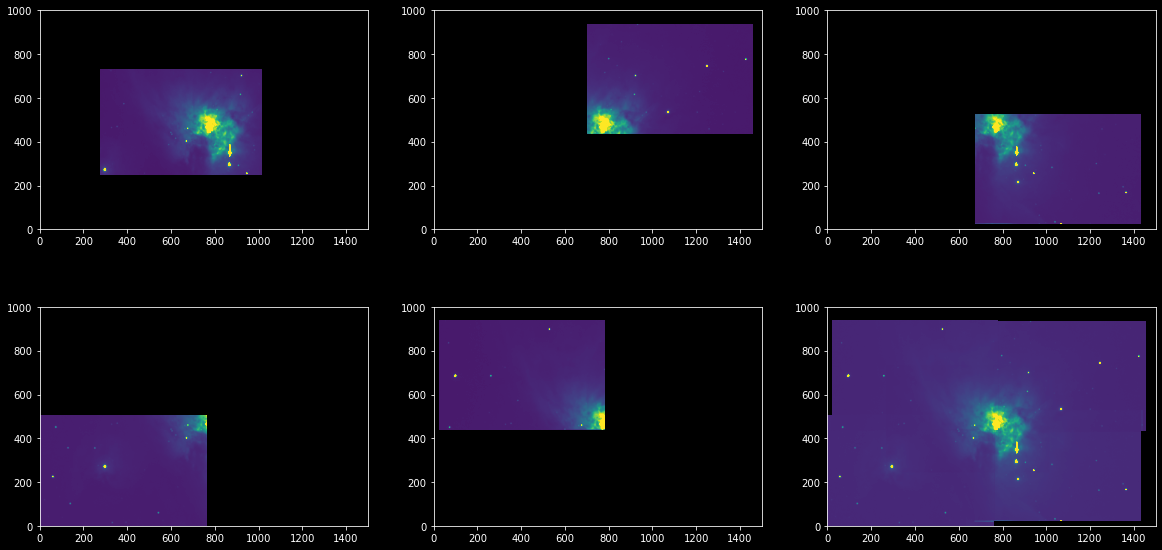

In [10]:
# these are 5 images that have already been aligned, combined, and then lined up into the final big mosaic frame
im1,im2,im3,im4,im5 = fits.getdata('data/m42_vband_deep_bgmatch_cube.fits')

pl.figure(figsize=(20,10))
pl.subplot(2,3,1).imshow(im1, vmin=100, vmax=3000); pl.axis((0,1500,0,1000))
pl.subplot(2,3,2).imshow(im2, vmin=100, vmax=3000); pl.axis((0,1500,0,1000))
pl.subplot(2,3,3).imshow(im3, vmin=100, vmax=3000); pl.axis((0,1500,0,1000))
pl.subplot(2,3,4).imshow(im4, vmin=100, vmax=3000); pl.axis((0,1500,0,1000))
pl.subplot(2,3,5).imshow(im5, vmin=100, vmax=3000); pl.axis((0,1500,0,1000))
pl.subplot(2,3,6).imshow(np.nanmean([im1,im2,im3,im4,im5], axis=0), vmin=-10, vmax=3000); pl.axis((0,1500,0,1000))

<ipython-input-11-3db0c1560d48>:7: RuntimeWarning: Mean of empty slice
  _=pl.subplot(2,3,6).hist(np.nanmean([im1,im2,im3,im4,im5], axis=0).ravel(), bins=np.linspace(200,3000))


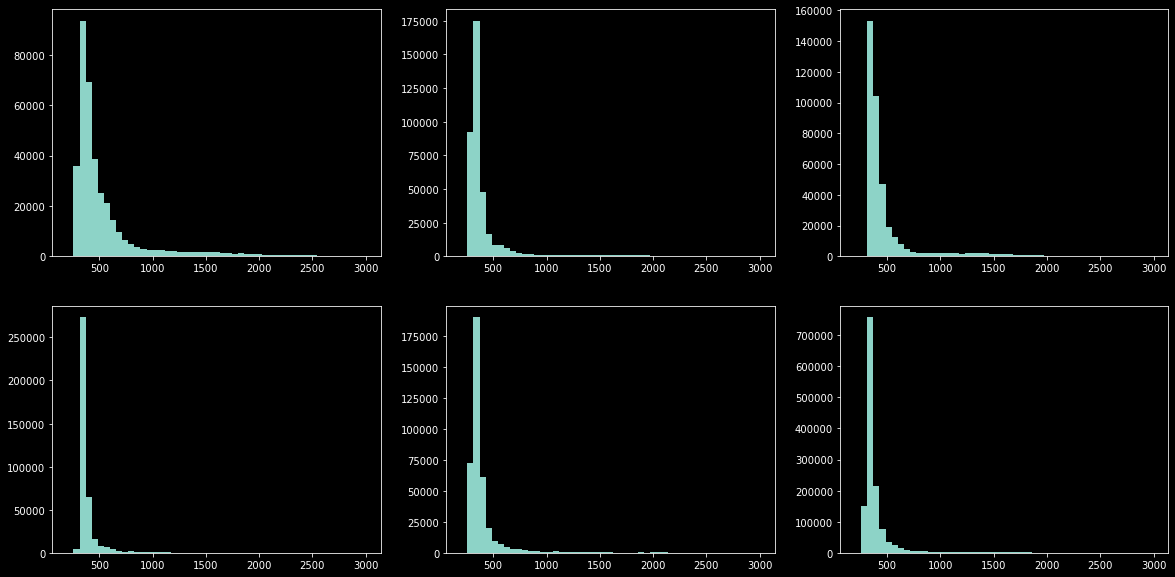

In [11]:
pl.figure(figsize=(20,10))
_=pl.subplot(2,3,1).hist(im1.ravel(), bins=np.linspace(200,3000));
_=pl.subplot(2,3,2).hist(im2.ravel(), bins=np.linspace(200,3000));
_=pl.subplot(2,3,3).hist(im3.ravel(), bins=np.linspace(200,3000));
_=pl.subplot(2,3,4).hist(im4.ravel(), bins=np.linspace(200,3000));
_=pl.subplot(2,3,5).hist(im5.ravel(), bins=np.linspace(200,3000));
_=pl.subplot(2,3,6).hist(np.nanmean([im1,im2,im3,im4,im5], axis=0).ravel(), bins=np.linspace(200,3000))

<ipython-input-12-29669ce78972>:1: RuntimeWarning: Mean of empty slice
  pl.imshow(np.nanmean([im1,im2,im3,im4,im5], axis=0), vmin=300, vmax=500); pl.axis((0,1500,0,1000))


(0.0, 1500.0, 0.0, 1000.0)

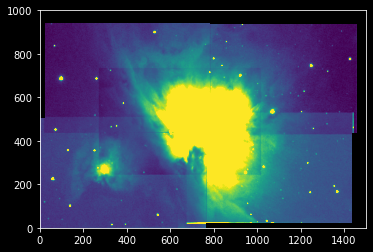

In [12]:
pl.imshow(np.nanmean([im1,im2,im3,im4,im5], axis=0), vmin=300, vmax=500); pl.axis((0,1500,0,1000))

We can see that the backgrouds aren't matched.

First thing, let's try the median-subtraction approach:

<ipython-input-13-97752a2c50f1>:2: RuntimeWarning: Mean of empty slice
  pl.imshow(np.nanmean(cube - np.nanmedian(cube, axis=(1,2))[:,None,None], axis=0), vmin=-100, vmax=100); pl.axis((0,1500,0,1000))


(0.0, 1500.0, 0.0, 1000.0)

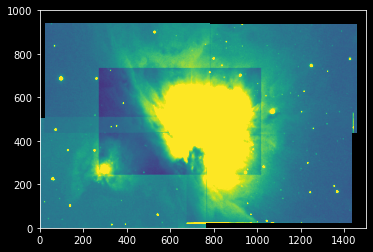

In [13]:
cube = np.array([im1,im2,im3,im4,im5])
pl.imshow(np.nanmean(cube - np.nanmedian(cube, axis=(1,2))[:,None,None], axis=0), vmin=-100, vmax=100); pl.axis((0,1500,0,1000))

## Aside


I'll take a moment to unwrap the clever python tricks here:

1. We assemble the 5 images into a cube
```
cube = np.array([im1,im2,im3,im4,im5])
```

2. We do some things that we'll break down more...
```
np.nanmean(cube - np.nanmedian(cube, axis=(1,2))[:,None,None], axis=0)
```

2.a. This step takes the median across the _spatial_ axes of the cube:
```
medians = np.nanmedian(cube, axis=(1,2))
```
it is equivalent to:
```
medians = [np.median(im1), np.median(im2), ...]
```

2.b. This step "broadcasts" the medians to the same shape as the cube:
```
result = cube - medians[:,None,None]
```
it is equivalent to:
```
result = [im1-medians[0], im2-medians[1], ...]
```

2.c. We take the nanmean across the 0'th axis:
```
np.nanmean(result, axis=0)
```


You don't need to use this approach, but if you learn to use it fluently, you can do a lot of things in python faster and easier.

However, it's really easy to make mistakes with this approach, so I recommend you use the written-out way if you're at all uncertain.

Since the median approach didn't work, we can try another simplistic approach: use the n'th percentile

<ipython-input-14-3bef67c96ac8>:2: RuntimeWarning: Mean of empty slice
  pl.imshow(np.nanmean(cube - np.nanpercentile(cube, 10, axis=(1,2))[:,None,None], axis=0), vmin=-50, vmax=150); pl.axis((0,1500,0,1000))


(0.0, 1500.0, 0.0, 1000.0)

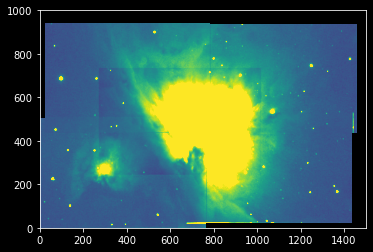

In [14]:
cube = np.array([im1,im2,im3,im4,im5])
pl.imshow(np.nanmean(cube - np.nanpercentile(cube, 10, axis=(1,2))[:,None,None], axis=0), vmin=-50, vmax=150); pl.axis((0,1500,0,1000))

That's not bad, but still not perfect.  We can also try taking cutouts and matching them.

In the case below, I spent some time to select regions that are mostly free of nebulosity (they're not bright).  I then had to fine-tune the estimate for the central pointing because it has nebulosity everywhere.  I used a simple guess-and-check process for this:

<ipython-input-15-9856302a1b82>:6: RuntimeWarning: Mean of empty slice
  pl.imshow(np.nanmean(cube - np.array([bg1,bg2,bg3,bg4,bg5])[:,None,None], axis=0), vmin=-50, vmax=150); pl.axis((0,1500,0,1000))


(0.0, 1500.0, 0.0, 1000.0)

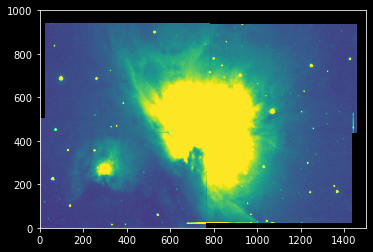

In [15]:
bg1 = np.percentile(im1[400:600,300:500],5)
bg2 = np.nanmedian(im2[500:700,1200:1400])
bg3 = np.nanmedian(im3[100:300,1200:1400])
bg4 = np.nanmedian(im4[100:300,400:600])
bg5 = np.nanmedian(im5[600:800,100:300])
pl.imshow(np.nanmean(cube - np.array([bg1,bg2,bg3,bg4,bg5])[:,None,None], axis=0), vmin=-50, vmax=150); pl.axis((0,1500,0,1000))

You can see that it worked pretty well!

<ipython-input-16-c71758e7d0f4>:1: RuntimeWarning: Mean of empty slice
  pl.imshow(np.nanmean(cube - np.array([bg1,bg2,bg3,bg4,bg5])[:,None,None], axis=0), vmin=-50, vmax=1500);


(0.0, 1500.0, 0.0, 1000.0)

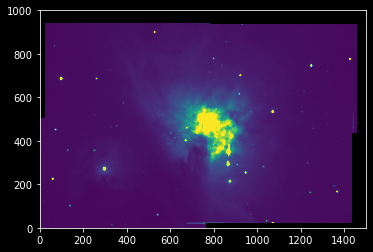

In [16]:
pl.imshow(np.nanmean(cube - np.array([bg1,bg2,bg3,bg4,bg5])[:,None,None], axis=0), vmin=-50, vmax=1500);
pl.axis((0,1500,0,1000))

If you can't get the above to work, there are other things to try, but this is the right starting point.

# Measuring Sky Brightness

The background-subtraction steps noted above are the same steps you would use to measure the sky brightness.

For a source like M42, you have to find a patch of sky that does not contain nebulosity.

The `bg1` though `bg5` values above are estimates of the sky brightness, though `bg1` is a _very poor_ estimate of the sky brightness because the nebula is so bright!

When measuring sky brightness, you also need to measure uncertainty on it.  The uncertainty is a combination of the per-pixel uncertainty and the pixel-to-pixel variation.

We can try to measure the uncertainty using the standard deviation, but it will be an overestimate because there are stars in the field:

In [17]:
bg1uncertainty = np.std(im1[400:600,300:500])
bg2uncertainty = np.std(im2[500:700,1200:1400])
bg3uncertainty = np.std(im3[100:300,1200:1400])
bg4uncertainty = np.std(im4[100:300,400:600])
bg5uncertainty = np.std(im5[600:800,100:300])

In [19]:
print(f"bg1: {bg1:0.1f} +/- {bg1uncertainty:0.1f}")
print(f"bg2: {bg2:0.1f} +/- {bg2uncertainty:0.1f}")
print(f"bg3: {bg3:0.1f} +/- {bg3uncertainty:0.1f}")
print(f"bg4: {bg4:0.1f} +/- {bg4uncertainty:0.1f}")
print(f"bg5: {bg5:0.1f} +/- {bg5uncertainty:0.1f}")

bg1: 299.1 +/- 37.0
bg2: 312.3 +/- 16.5
bg3: 353.7 +/- 193.6
bg4: 344.2 +/- 15.9
bg5: 316.0 +/- 155.2


We can use the ``mad_std`` estimator (the Median Absolute Deviation) as a robust estimator:

In [20]:
from astropy.stats import mad_std

In [21]:
bg1uncertainty = mad_std(im1[400:600,300:500])
bg2uncertainty = mad_std(im2[500:700,1200:1400])
bg3uncertainty = mad_std(im3[100:300,1200:1400])
bg4uncertainty = mad_std(im4[100:300,400:600])
bg5uncertainty = mad_std(im5[600:800,100:300])

In [22]:
print(f"bg1: {bg1:0.1f} +/- {bg1uncertainty:0.1f}")
print(f"bg2: {bg2:0.1f} +/- {bg2uncertainty:0.1f}")
print(f"bg3: {bg3:0.1f} +/- {bg3uncertainty:0.1f}")
print(f"bg4: {bg4:0.1f} +/- {bg4uncertainty:0.1f}")
print(f"bg5: {bg5:0.1f} +/- {bg5uncertainty:0.1f}")

bg1: 299.1 +/- 18.5
bg2: 312.3 +/- 11.6
bg3: 353.7 +/- 11.1
bg4: 344.2 +/- 14.7
bg5: 316.0 +/- 11.3


To get the uncertainty technically correct, you would compare the uncertainty above (about 11-18 counts) to the uncertainty on the mean, which is the per-pixel uncertainty divided by sqrt(N_pixels).  You should expect, though, that the uncertainty on the mean is much smaller than the pixel-to-pixel variation.

In the lab, you will need to convert these sky brightness numbers to a calibrated value, i.e., magnitudes per square arcsecond.